In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from preprocessing import PastUserState,extract_data_mooc,PreviousItemInteraction, extractFeatures,extractItemUserId,extractPastItem,extractNextUserState,UserNextInteraction, delta, t_batch_update,train_test_split,train_test_stratified_split
from model import RODIE
from sklearn.manifold import TSNE
from train import dynamic_embedding,train_rodie
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
import math
from torch.nn import functional as F
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from tqdm import tqdm


torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [2]:
## Téléchargement des données
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-21 15:17:33--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz’

act-mooc.tar.gz     100%[===================>]   5.13M  15.9MB/s    in 0.3s    

2022-03-21 15:17:34 (15.9 MB/s) - ‘act-mooc.tar.gz’ saved [5378133/5378133]



In [3]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [4]:
mooc_data = extract_data_mooc()


In [5]:
delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
PreviousItemInteraction_ = PreviousItemInteraction(mooc_data.copy()).astype(int)
next_state_user = PastUserState(mooc_data.copy()).astype(int)

interaction_column_name = "PreviousItemInteraction"
pastState_column_name =  "previous_state_label"

delta user_id
delta item_id


In [6]:
mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)
mooc_data[interaction_column_name] = PreviousItemInteraction_
mooc_data[pastState_column_name] = next_state_user
list_moins_un = list(mooc_data[mooc_data[pastState_column_name] == -1].index.values)
mooc_data.loc[list_moins_un,pastState_column_name] = 0
data = mooc_data.copy()
#data = data[data.next_state_user != -1]

data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', interaction_column_name, pastState_column_name,'f1', 'f2', 'f3','f4']].sort_values(['timestamp'])
data

,user_id,item_id,timestamp,state_label,delta_u,delta_i,PreviousItemInteraction,previous_state_label,f1,f2,f3,f4
ACTIONID,,,,,,,,,,,,
0,0,0,0.0,0,0.000000,0.000000,-1,0,-0.319991,-0.435701,0.106784,-0.067309
1,0,1,6.0,0,0.000064,0.000000,0,0,-0.319991,-0.435701,0.106784,-0.067309
2,0,2,41.0,0,0.000372,0.000000,1,0,-0.319991,-0.435701,0.106784,-0.067309
3,0,1,49.0,0,0.000085,0.007652,2,0,-0.319991,-0.435701,0.106784,-0.067309
4,0,2,51.0,0,0.000021,0.001780,1,0,-0.319991,-0.435701,0.106784,-0.067309
...,...,...,...,...,...,...,...,...,...,...,...,...
411744,7026,8,2572041.0,0,0.511035,0.496339,71,0,-0.319991,-0.435701,0.106784,-0.067309
411745,6842,8,2572043.0,0,0.859978,0.000356,8,0,-0.319991,-0.435701,0.106784,-0.067309
411746,7026,9,2572048.0,0,0.000074,0.075990,8,0,-0.319991,-0.435701,0.106784,-0.067309


### T-batches

#### Train / Test SPLIT

In [7]:
t_batches_train = t_batch_update(data)


T-Batch start...
Number of interaction = 411749
T-Batch ends !


In [8]:
len(t_batches_train)

63461

##### Initialize Device

In [9]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [45]:
# Test le modèle sur peu de données
import itertools
interactions_ = []
n_batches = 50000
t_batches_ = dict(itertools.islice(t_batches_train.items(), n_batches))
number_of_interactions = 0
for x,y in t_batches_.items():
  number_of_interactions +=(len(y))
  interactions_.append(y)
interactions = list(itertools.chain(*interactions_)) # Flatten the list of list
print("Number of interactions in {} batches is equal to {}".format(n_batches,number_of_interactions))

Number of interactions in 50000 batches is equal to 318977


In [48]:
# Its important to add this to the loss, because the dataset is unbalanced
dropout_ratio = len(interactions)/(1.0+ np.sum(data.loc[interactions,'state_label']))
weight_ratio = torch.Tensor([1.0,dropout_ratio]).to(device)
print("Number of dropout in the train data is {}".format(np.sum(data.loc[interactions,'state_label'])))

Number of dropout in the train data is 3194


In [49]:
embedding_dim = 32
data_torch = torch.from_numpy(data.values.astype(np.float32))
model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="tanh").to(device)

Number of users of 7047 
 Number of items 97 

Dataset size [411749, 12]
Initialisation of static embedding... Done !
Static Embedding shape : Users [7047, 7047], 	 Items [98, 98]
Initialisation of rnn's with tanh activation function... Done !
Initialisation of MLP... Done !


##### Train Loop

In [50]:

from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from preprocessing import *
import torch
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
import math
from tqdm import tqdm
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from torch.nn import functional as F

def dynamic_embedding(data,embedding_dim):
        num_users = len(torch.unique(data[:,0]))
        num_items = len(torch.unique(data[:,1]))
        dynamic_users_embedding = F.normalize(torch.randn(embedding_dim).repeat(num_users,1),dim=0)#nn.init.kaiming_uniform_(w, mode='fan_in', nonlinearity='relu')#F.normalize(torch.randn(num_users,embedding_dim))
        dynamic_items_embedding = F.normalize(torch.randn(embedding_dim).repeat(num_items+1,1),dim=0)

        print("Initialisation of dynamic embedding... Done !")
        print("Dynamic Embedding shape : Users {}, \t Items {}".format(list(dynamic_users_embedding.size()),list(dynamic_items_embedding.size())))

        return dynamic_users_embedding,dynamic_items_embedding



def regularizer(actual_user_embedding,future_user_embedding,lambda_u,
                               actual_item_embedding,future_item_embedding,lambda_i
                               ):
    u_regularization_loss =  MSELoss()(actual_user_embedding,future_user_embedding)
    i_regularization_loss =  MSELoss()(actual_item_embedding,future_item_embedding)
    return lambda_u* u_regularization_loss + lambda_i* i_regularization_loss 


def train_rodie(t_batches,
          data,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device,

          ):

  U,I = dynamic_embedding(data,model.embedding_dim)  # Initial dynamic embedding
    
  U = U.to(device)
  I = I.to(device)
  print("Training...")
 # U_copy = U.clone().detach()
 # I_copy = I.clone().detach()
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
  for e in range(n_epochs):
    l = 0
    
    for (_,rows),_ in zip(t_batches.items(),tqdm(range(len(t_batches)), position=0, leave=True)):
      optimizer.zero_grad()
      users_idx,items_idx = extractItemUserId(data,rows)
      state_label,delta_u,delta_i,f = extractFeatures(data,rows)
      next_item = extractPastItem(data,rows)
      u_static, i_static = model.static_users_embedding[users_idx], model.static_items_embedding[items_idx]


      user_embedding, item_embedding = U[users_idx], I[items_idx]
      next_item_static_embedding, next_item_dynamic_embedding = model.static_items_embedding[[int(x) for x in next_item]], I[[int(x) for x in next_item]]

      u_static = u_static.to(device)
      i_static = i_static.to(device)
      f = f.to(device)
      delta_u = delta_u.to(device)
      delta_i = delta_i.to(device)
      state_label = state_label.type(torch.LongTensor).to(device)
      next_item_dynamic_embedding = next_item_dynamic_embedding.to(device)
      next_item_static_embedding = next_item_static_embedding.to(device)
      
      # The forward pass of the model : extract dynamic embeddings (user+item ), and predicted user state and predicted item embedding
      future_user_embedding,future_item_embedding,U_pred_state,j_tilde,j_true = model(item_embedding,
                user_embedding,
                u_static,
                i_static,
                f,
                delta_u,
                delta_i,
                next_item_dynamic_embedding,
                next_item_static_embedding)
      # Add the new embedding to the placeholder U and I
      U[users_idx] = future_user_embedding.detach()
      I[items_idx] = future_item_embedding.detach()
      
      # Return loss value between the predicted embedding "j_tilde" and the real next item embedding j_true
      
      loss = MSELoss()(j_tilde,j_true)#.detach()
      loss += regularizer(user_embedding.detach(),future_user_embedding,lambda_u,
                            item_embedding.detach(),future_item_embedding,lambda_i
                            )
      
      loss += CrossEntropyLoss(weight_ratio)(U_pred_state,state_label)
      #print(I[0])
      loss.backward()
      l += loss.item()
     # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=100.)
      optimizer.step()

    #scheduler.step(loss)
    print("Epoch {} Loss {}".format(e,l))

  return model,U,I


In [ ]:
n_epochs = 10
lambda_u = 1
lambda_i = 1
learning_rate=1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model_,U,I = train_rodie(t_batches_,
          data_torch,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]
Training...


 13%|█▎        | 6293/50000 [00:31<03:43, 195.66it/s]

In [27]:
dd = list(np.unique(data.loc[interactions,'user_id']))

In [28]:
len(dd)

3137

## TSNE

In [29]:
dd = sum(interactions_, [])
new_df = data.iloc[interactions,:].copy()
list_of_change = new_df[new_df['state_label'] == 1]['user_id'].values
data_  = (U.detach().cpu().clone()).numpy()
df = pd.DataFrame(data_)
df['label'] = np.zeros((7047,1))
for index, row in df.iterrows():
    for d in list_of_change:
      if index == d:
        df.iloc[index,-1] = 1

len(list_of_change)

571

In [30]:
tsne = TSNE(2)
data_tsne = tsne.fit_transform(data_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [31]:
dd = list(np.unique(data.loc[dd,'user_id']))

In [32]:
df[['t1','t2']] = data_tsne
dff = df.loc[dd]

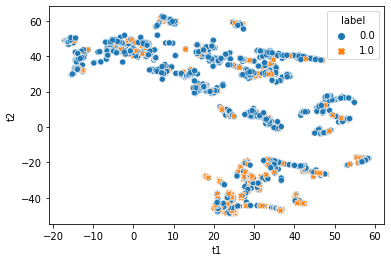

In [33]:
import seaborn as sns
sns.scatterplot(data=dff, x="t1", y="t2", hue="label",style="label")

In [ ]:
tsne = TSNE(2)
n_items = list(np.unique(data.loc[interactions,'item_id']))
data_tsne = tsne.fit_transform(I.detach().cpu().clone())
plt.scatter(data_tsne[n_items,0],data_tsne[n_items,1])